In [5]:
import pandas as pd
import matplotlib.pyplot as plt


In [11]:
import pandas as pd

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"

df = pd.read_csv(path)

# replace all NaN with 0000
df = df.fillna(0000)

# overwrite the same CSV
df.to_csv(path, index=False)

df.tail()

,Index,Type,Lat,Lon,Year made,fcb to zigzag,Circular FCB to Zigzag,circular FCB to Oval FCB,ZigZag to FCB,Year Demolished
791,791,1,28.99912,77.44388,2009,2018,0.0,0.0,0.0,0
792,792,1,28.23366,77.41032,2015,2018,0.0,0.0,0.0,0
793,793,1,28.22596,77.41453,2018,2018,0.0,0.0,0.0,0
794,794,1,28.74257,77.43613,2010,2017,0.0,0.0,0.0,0
795,795,1,28.73612,77.44105,2010,2020,0.0,0.0,0.0,0


In [9]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import geemap

# paths
points_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed.csv"

# ---------- load points ----------
df = pd.read_csv(points_path)

# ensure numeric
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")

# drop rows with invalid coords
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# ---------- load polygons (CSV with WKT geometry) ----------
df_polys = pd.read_csv(polys_path)

# parse WKT -> shapely geometry
df_polys["geometry"] = df_polys["geometry"].apply(wkt.loads)

gdf_polys = gpd.GeoDataFrame(df_polys, geometry="geometry", crs="EPSG:4326")

# ---------- spatial join ----------
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[["class_name", "Name", "geometry"]],
    how="left",
    predicate="within"
)

# ---------- counts ----------
count_by_name = (
    joined.groupby("Name", dropna=False)
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

count_by_class = (
    joined.groupby("class_name", dropna=False)
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("Count by polygon Name (NaN = outside all polygons):")
print(count_by_name.to_string(index=False))

print("\nCount by class_name (NaN = outside all polygons):")
print(count_by_class.to_string(index=False))

# ---------- geemap plot ----------
inside = joined[~joined["Name"].isna()].copy()
outside = joined[joined["Name"].isna()].copy()

m = geemap.Map(center=[28.6, 77.2], zoom=9)
m.add_basemap("SATELLITE")

m.add_gdf(
    gdf_polys,
    layer_name="Delhi airshed polygons",
    style={"color": "yellow", "fillColor": "#00000000", "weight": 2}
)

m.add_gdf(
    inside,
    layer_name="Kilns inside airshed",
    style={"color": "red", "pointSize": 5}
)

m.add_gdf(
    outside,
    layer_name="Kilns outside airshed",
    style={"color": "cyan", "pointSize": 4}
)

m

Count by polygon Name (NaN = outside all polygons):
         Name  count
delhi_airshed    718
          NaN     80

Count by class_name (NaN = outside all polygons):
class_name  count
    Zigzag    684
       NaN     80
      FCBK     34


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [10]:
# number of points that do NOT fall inside any polygon
num_outside = joined["Name"].isna().sum()

# total points
total_points = len(joined)

print(f"Total markers          : {total_points}")
print(f"Markers outside polygons: {num_outside}")
print(f"Markers inside polygons : {total_points - num_outside}")

Total markers          : 798
Markers outside polygons: 80
Markers inside polygons : 718


In [20]:
# pick a unique polygon id column
poly_id = "index" if "index" in gdf_polys.columns else "__poly_id__"
if poly_id == "__poly_id__":
    gdf_polys[poly_id] = gdf_polys.index

# spatial join with polygon id
joined2 = gpd.sjoin(
    gdf_points,
    gdf_polys[[poly_id, "class_name", "Name", "geometry"]],
    how="left",
    predicate="within"
)

# markers per polygon (only inside)
poly_marker_counts = (
    joined2.dropna(subset=[poly_id])
    .groupby(poly_id)
    .size()
    .rename("marker_count")
    .reset_index()
    .sort_values("marker_count", ascending=False)
)

print("Top polygons by marker_count:")
print(poly_marker_counts.head(20).to_string(index=False))

# how many polygons have >=2 markers (same polygon)
polys_with_multiple = poly_marker_counts[poly_marker_counts["marker_count"] >= 2]
print("\nPolygons with >=2 markers:", len(polys_with_multiple))

# how many markers are in those multi-marker polygons (total duplicates mass)
markers_in_multi_polys = polys_with_multiple["marker_count"].sum()
extra_markers_due_to_duplicates = (polys_with_multiple["marker_count"] - 1).sum()

print("Total markers inside polygons:", len(joined2.dropna(subset=[poly_id])))
print("Markers that lie in multi-marker polygons:", int(markers_in_multi_polys))
print("Extra markers beyond 1 per polygon:", int(extra_markers_due_to_duplicates))

# optional: attach counts back to polygons for mapping/inspection
gdf_polys_counts = gdf_polys.merge(poly_marker_counts, on=poly_id, how="left")
gdf_polys_counts["marker_count"] = gdf_polys_counts["marker_count"].fillna(0).astype(int)

# list polygons with multiple markers with metadata
cols = [poly_id] + [c for c in ["Name", "class_name"] if c in gdf_polys_counts.columns] + ["marker_count"]
print("\nPolygons having multiple markers:")
print(gdf_polys_counts[gdf_polys_counts["marker_count"] >= 2][cols].sort_values("marker_count", ascending=False).to_string(index=False))

Top polygons by marker_count:
 __poly_id__  marker_count
       633.0             2
       576.0             2
       588.0             2
       587.0             2
        79.0             2
       267.0             2
        71.0             2
       162.0             2
       336.0             2
        67.0             2
        64.0             2
       150.0             2
        61.0             2
        59.0             2
       261.0             2
       434.0             2
       258.0             2
        54.0             2
       347.0             2
       569.0             2

Polygons with >=2 markers: 66
Total markers inside polygons: 718
Markers that lie in multi-marker polygons: 132
Extra markers beyond 1 per polygon: 66

Polygons having multiple markers:
 __poly_id__          Name class_name  marker_count
           3 delhi_airshed     Zigzag             2
         462 delhi_airshed     Zigzag             2
         305 delhi_airshed     Zigzag             2
        

In [21]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import geemap

points_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed.csv"

# points
df = pd.read_csv(points_path)
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# polygons (CSV WKT)
df_polys = pd.read_csv(polys_path)
df_polys["geometry"] = df_polys["geometry"].apply(wkt.loads)
gdf_polys = gpd.GeoDataFrame(df_polys, geometry="geometry", crs="EPSG:4326")

# unique polygon id
poly_id = "index" if "index" in gdf_polys.columns else "__poly_id__"
if poly_id == "__poly_id__":
    gdf_polys[poly_id] = gdf_polys.index

# join
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[[poly_id, "geometry"]],
    how="left",
    predicate="within"
)

# counts per polygon
counts = (
    joined.dropna(subset=[poly_id])
    .groupby(poly_id)
    .size()
    .rename("marker_count")
    .reset_index()
)

# polygons with >=2 markers
polys_multi = gdf_polys.merge(counts, on=poly_id, how="left")
polys_multi["marker_count"] = polys_multi["marker_count"].fillna(0).astype(int)
polys_multi = polys_multi[polys_multi["marker_count"] >= 2]

# markers that fall in those polygons
multi_ids = set(polys_multi[poly_id].tolist())
markers_multi = joined[joined[poly_id].isin(multi_ids)].copy()

print("Polygons with >=2 markers:", len(polys_multi))
print("Markers inside those polygons:", len(markers_multi))

# geemap plot (only these)
m = geemap.Map(center=[28.6, 77.2], zoom=9)
m.add_basemap("SATELLITE")

m.add_gdf(
    polys_multi,
    layer_name="Polygons with >=2 markers",
    style={"color": "lime", "fillColor": "#00000000", "weight": 3}
)

m.add_gdf(
    markers_multi,
    layer_name="Markers in those polygons",
    style={"color": "red", "pointSize": 6}
)

m

Polygons with >=2 markers: 66
Markers inside those polygons: 132


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [22]:
import pandas as pd

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"

df = pd.read_csv(path)

# ensure numeric
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")

df = df.dropna(subset=["Lat", "Lon"]).copy()

# count occurrences of each (Lat, Lon)
latlon_counts = (
    df.groupby(["Lat", "Lon"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

# only common (duplicates)
duplicates = latlon_counts[latlon_counts["count"] > 1]

print("Total rows:", len(df))
print("Unique Lat–Lon pairs:", len(latlon_counts))
print("Duplicate Lat–Lon pairs:", len(duplicates))
print("Total duplicate rows (extra beyond 1):", int((duplicates["count"] - 1).sum()))

print("\nDuplicate Lat–Lon pairs:")
print(duplicates.to_string(index=False))

Total rows: 796
Unique Lat–Lon pairs: 792
Duplicate Lat–Lon pairs: 4
Total duplicate rows (extra beyond 1): 4

Duplicate Lat–Lon pairs:
     Lat      Lon  count
28.29928 77.05538      2
28.89475 77.25475      2
28.78600 77.35718      2
28.93150 76.91468      2


In [ ]:
# ---- polygons with >=2 markers (which polygons) ----
cols_poly = [poly_id]
if "Name" in gdf_polys.columns: cols_poly.append("Name")
if "class_name" in gdf_polys.columns: cols_poly.append("class_name")
cols_poly.append("marker_count")

polys_multi_table = polys_multi[cols_poly].sort_values("marker_count", ascending=False)
print("Polygons with >=2 markers (sorted):")
print(polys_multi_table.to_string(index=False))

print("\nHow many polygons have >=2 markers:", len(polys_multi_table))

# ---- corresponding rows from your point CSV (which markers fall in those polygons) ----
# keep original point columns (drop geometry)
point_cols = [c for c in df.columns if c not in ["geometry"]]

# markers_multi currently is the joined GeoDataFrame; get its point rows + polygon id
markers_multi_rows = markers_multi[point_cols + [poly_id]].copy()

# sort by polygon then by lat/lon for readability
markers_multi_rows = markers_multi_rows.sort_values([poly_id, "Lat", "Lon"])

print("\nPoint-CSV rows that belong to polygons with >=2 markers:")
print(markers_multi_rows.to_string(index=False))

# # optional: save both outputs
# out_poly = points_path.replace(".csv", "_polygons_ge2_markers.csv")
# out_pts  = points_path.replace(".csv", "_points_in_polygons_ge2_markers.csv")
# polys_multi_table.to_csv(out_poly, index=False)
# markers_multi_rows.to_csv(out_pts, index=False)
# print("\nSaved:")
# print(out_poly)
# print(out_pts)

Polygons with >=2 markers (sorted):
 __poly_id__          Name class_name  marker_count
           3 delhi_airshed     Zigzag             2
         462 delhi_airshed     Zigzag             2
         305 delhi_airshed     Zigzag             2
         313 delhi_airshed     Zigzag             2
         314 delhi_airshed     Zigzag             2
         317 delhi_airshed     Zigzag             2
         336 delhi_airshed     Zigzag             2
         347 delhi_airshed     Zigzag             2
         370 delhi_airshed     Zigzag             2
         388 delhi_airshed     Zigzag             2
         398 delhi_airshed     Zigzag             2
         400 delhi_airshed     Zigzag             2
         412 delhi_airshed     Zigzag             2
         423 delhi_airshed       FCBK             2
         434 delhi_airshed     Zigzag             2
         454 delhi_airshed       FCBK             2
         469 delhi_airshed     Zigzag             2
           5 delhi_airshed  

In [29]:
# work on the joined dataframe so polygon id is available
df_dedup = markers_multi.copy()

# ensure year is numeric
df_dedup["Year made"] = pd.to_numeric(df_dedup["Year made"], errors="coerce")

# sort to make keep-first deterministic (optional)
df_dedup = df_dedup.sort_values([poly_id, "Year made", "Lat", "Lon"])

# drop duplicates: same polygon + same year
df_dedup = df_dedup.drop_duplicates(
    subset=[poly_id, "Year made"],
    keep="first"
)

print("Rows after removing same-year duplicates per polygon:", len(df_dedup))

print(df_dedup.head())
print(df_dedup.to_string(index=False))


Rows after removing same-year duplicates per polygon: 71
     Index  Type       Lat       Lon  Year made  fcb to zigzag  \
527    527     1  28.94546  76.91489       2015           2017   
668    668     1  28.89266  77.02469       2009           2015   
592    592     1  28.93150  76.91468       2011           2017   
560    560     1  28.25142  77.40510       2010           2019   
265    265     1  28.92216  76.88463       2011           2019   

     Circular FCB to Zigzag  circular FCB to Oval FCB  ZigZag to FCB  \
527                     0.0                       0.0            0.0   
668                     0.0                       0.0            0.0   
592                     0.0                       0.0            0.0   
560                     0.0                       0.0            0.0   
265                     0.0                       0.0            0.0   

    Year Demolished                   geometry  index_right  __poly_id__  
527               0  POINT (76.91489 2

In [30]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

points_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed.csv"

# ---------------- points ----------------
df = pd.read_csv(points_path)
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# ---------------- polygons ----------------
df_polys = pd.read_csv(polys_path)
df_polys["geometry"] = df_polys["geometry"].apply(wkt.loads)
gdf_polys = gpd.GeoDataFrame(df_polys, geometry="geometry", crs="EPSG:4326")

poly_id = "index" if "index" in gdf_polys.columns else "__poly_id__"
if poly_id == "__poly_id__":
    gdf_polys[poly_id] = gdf_polys.index

# ---------------- join + identify duplicate polygons ----------------
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[[poly_id, "geometry"]],
    how="left",
    predicate="within"
)

# polygons that have >=2 markers (ignore outside polygons)
poly_counts = joined.dropna(subset=[poly_id]).groupby(poly_id).size()
dup_poly_ids = poly_counts[poly_counts >= 2].index.tolist()

# rows in those polygons
dup_rows = joined[joined[poly_id].isin(dup_poly_ids)].copy()

# ---------------- drop "second one" (keep first per polygon) ----------------
# deterministic ordering: keep the first after sorting
dup_rows = dup_rows.sort_values([poly_id, "Lat", "Lon"])

keep_first_idx = dup_rows.groupby(poly_id, sort=False).head(1).index
drop_idx = dup_rows.index.difference(keep_first_idx)

print("Duplicate polygons:", len(dup_poly_ids))
print("Rows to drop (second+ in each duplicate polygon):", len(drop_idx))

# drop from original df using the same indices (joined kept original index)
df_clean = df.drop(index=drop_idx)

# ---------------- save ----------------
out_path = points_path.replace(".csv", "_dedup_one_marker_per_polygon.csv")
df_clean.to_csv(out_path, index=False)
print("Saved:", out_path)

Duplicate polygons: 66
Rows to drop (second+ in each duplicate polygon): 65
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_dedup_one_marker_per_polygon.csv


In [32]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import geemap

# paths
points_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_dedup_one_marker_per_polygon.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed.csv"

# ---------- load points ----------
df = pd.read_csv(points_path)

# ensure numeric
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")

# drop rows with invalid coords
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# ---------- load polygons (CSV with WKT geometry) ----------
df_polys = pd.read_csv(polys_path)

# parse WKT -> shapely geometry
df_polys["geometry"] = df_polys["geometry"].apply(wkt.loads)

gdf_polys = gpd.GeoDataFrame(df_polys, geometry="geometry", crs="EPSG:4326")

# ---------- spatial join ----------
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[["class_name", "Name", "geometry"]],
    how="left",
    predicate="within"
)

# ---------- counts ----------
count_by_name = (
    joined.groupby("Name", dropna=False)
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

count_by_class = (
    joined.groupby("class_name", dropna=False)
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("Count by polygon Name (NaN = outside all polygons):")
print(count_by_name.to_string(index=False))

print("\nCount by class_name (NaN = outside all polygons):")
print(count_by_class.to_string(index=False))

# ---------- geemap plot ----------
inside = joined[~joined["Name"].isna()].copy()
outside = joined[joined["Name"].isna()].copy()

m = geemap.Map(center=[28.6, 77.2], zoom=9)
m.add_basemap("SATELLITE")

m.add_gdf(
    gdf_polys,
    layer_name="Delhi airshed polygons",
    style={"color": "yellow", "fillColor": "#00000000", "weight": 2}
)

m.add_gdf(
    inside,
    layer_name="Kilns inside airshed",
    style={"color": "red", "pointSize": 5}
)

m.add_gdf(
    outside,
    layer_name="Kilns outside airshed",
    style={"color": "cyan", "pointSize": 4}
)

m

Count by polygon Name (NaN = outside all polygons):
         Name  count
delhi_airshed    652
          NaN     80

Count by class_name (NaN = outside all polygons):
class_name  count
    Zigzag    621
       NaN     80
      FCBK     31


Map(center=[28.6, 77.2], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

In [33]:
# number of points that do NOT fall inside any polygon
num_outside = joined["Name"].isna().sum()

# total points
total_points = len(joined)

print(f"Total markers          : {total_points}")
print(f"Markers outside polygons: {num_outside}")
print(f"Markers inside polygons : {total_points - num_outside}")

Total markers          : 732
Markers outside polygons: 80
Markers inside polygons : 652


In [34]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

points_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_dedup_one_marker_per_polygon.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed.csv"

# ---------- points ----------
df = pd.read_csv(points_path)
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# ---------- polygons (CSV WKT) ----------
df_polys = pd.read_csv(polys_path)
df_polys["geometry"] = df_polys["geometry"].apply(wkt.loads)
gdf_polys = gpd.GeoDataFrame(df_polys, geometry="geometry", crs="EPSG:4326")

# choose unique polygon id
poly_id = "index" if "index" in gdf_polys.columns else "__poly_id__"
if poly_id == "__poly_id__":
    gdf_polys[poly_id] = gdf_polys.index

# ---------- spatial join (polygon id only) ----------
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[[poly_id, "geometry"]],
    how="left",
    predicate="within"
)

# polygons that have >=1 marker
hit_ids = set(joined.dropna(subset=[poly_id])[poly_id].unique().tolist())

# split polygons
gdf_with = gdf_polys[gdf_polys[poly_id].isin(hit_ids)].copy()
gdf_without = gdf_polys[~gdf_polys[poly_id].isin(hit_ids)].copy()

print("Total polygons:", len(gdf_polys))
print("Polygons WITH markers:", len(gdf_with))
print("Polygons WITHOUT markers:", len(gdf_without))

# ---------- save as CSV (keep WKT geometry) ----------
df_with = gdf_with.copy()
df_without = gdf_without.copy()
df_with["geometry"] = df_with["geometry"].apply(lambda g: g.wkt)
df_without["geometry"] = df_without["geometry"].apply(lambda g: g.wkt)

out_with = polys_path.replace(".csv", "_WITH_markers.csv")
out_without = polys_path.replace(".csv", "_WITHOUT_markers.csv")

df_with.to_csv(out_with, index=False)
df_without.to_csv(out_without, index=False)

print("Saved:", out_with)
print("Saved:", out_without)

Total polygons: 753
Polygons WITH markers: 652
Polygons WITHOUT markers: 101
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers.csv
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers.csv


In [ ]:
import pandas as pd

report_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/download_report_all.csv"
polys_path  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers.csv"
/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers.csv

YEAR = 2025

# ------------------ load ------------------
rep = pd.read_csv(report_path)
pol = pd.read_csv(polys_path)

# ------------------ normalize polygon centroids to filename format ------------------
pol["center_lat_6"] = pd.to_numeric(pol["center_lat"], errors="coerce").map(lambda x: f"{x:.6f}")
pol["center_lon_6"] = pd.to_numeric(pol["center_lon"], errors="coerce").map(lambda x: f"{x:.6f}")

pol["expected_fname"] = pol["center_lat_6"] + "_" + pol["center_lon_6"] + f"_{YEAR}.png"

# report already has full relative path; extract basename
rep["fname"] = rep["path"].astype(str).str.split("/").str[-1]

# ------------------ mapping (polygon row -> image row) ------------------
mapped = pol.merge(
    rep[["idx", "center_lat", "center_lon", "year", "status", "crop_size", "path", "fname"]],
    left_on="expected_fname",
    right_on="fname",
    how="left",
    indicator=True
)

# ------------------ diagnostics ------------------
print("Total polygons:", len(pol))
print("Matched to images:", (mapped["_merge"] == "both").sum())
print("No match:", (mapped["_merge"] != "both").sum())
print("\nStatus counts among matched:")
print(mapped.loc[mapped["_merge"] == "both", "status"].value_counts(dropna=False))

# ------------------ save mapping ------------------
out_path = polys_path.replace(".csv", "_mapped_to_download_report.csv")
mapped.to_csv(out_path, index=False)
print("Saved:", out_path)

# optional: only unmatched polygons
out_unmatched = polys_path.replace(".csv", "_unmatched_to_download_report.csv")
mapped[mapped["_merge"] != "both"].to_csv(out_unmatched, index=False)
print("Saved:", out_unmatched)

Total polygons: 652
Matched to images: 618
No match: 34

Status counts among matched:
ok    618
Name: status, dtype: int64
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_mapped_to_download_report.csv
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_unmatched_to_download_report.csv


In [45]:
import pandas as pd

report_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/download_report_all.csv"
with_path   = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers.csv"
without_path= "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers.csv"

YEAR = 2025

rep = pd.read_csv(report_path)
rep["fname"] = rep["path"].astype(str).str.split("/").str[-1]

def map_polygons(poly_csv_path: str, tag: str):
    pol = pd.read_csv(poly_csv_path)

    pol["center_lat_6"] = pd.to_numeric(pol["center_lat"], errors="coerce").map(lambda x: f"{x:.6f}")
    pol["center_lon_6"] = pd.to_numeric(pol["center_lon"], errors="coerce").map(lambda x: f"{x:.6f}")
    pol["expected_fname"] = pol["center_lat_6"] + "_" + pol["center_lon_6"] + f"_{YEAR}.png"
    pol["marker_flag"] = tag  # WITH or WITHOUT

    mapped = pol.merge(
        rep[["idx", "center_lat", "center_lon", "year", "status", "crop_size", "path", "fname"]],
        left_on="expected_fname",
        right_on="fname",
        how="left",
        indicator=True
    )

    out_all = poly_csv_path.replace(".csv", "_mapped_to_download_report.csv")
    out_unmatched = poly_csv_path.replace(".csv", "_unmatched_to_download_report.csv")

    mapped.to_csv(out_all, index=False)
    mapped[mapped["_merge"] != "both"].to_csv(out_unmatched, index=False)

    print(f"\n[{tag}] Total polygons:", len(pol))
    print(f"[{tag}] Matched to images:", (mapped['_merge'] == 'both').sum())
    print(f"[{tag}] No match:", (mapped['_merge'] != 'both').sum())

    return mapped, out_all, out_unmatched

mapped_with, out_with_all, out_with_unmatched = map_polygons(with_path, "WITH")
mapped_without, out_wo_all, out_wo_unmatched  = map_polygons(without_path, "WITHOUT")

# combined mapping file (both CSVs together)
combined = pd.concat([mapped_with, mapped_without], ignore_index=True)
combined_out = report_path.replace("download_report_all.csv", "polygons_WITH_AND_WITHOUT_mapped_to_download_report.csv")
combined.to_csv(combined_out, index=False)

print("\nSaved combined:", combined_out)
print("Saved WITH:", out_with_all)
print("Saved WITH unmatched:", out_with_unmatched)
print("Saved WITHOUT:", out_wo_all)
print("Saved WITHOUT unmatched:", out_wo_unmatched)


[WITH] Total polygons: 652
[WITH] Matched to images: 618
[WITH] No match: 34

[WITHOUT] Total polygons: 101
[WITHOUT] Matched to images: 88
[WITHOUT] No match: 13

Saved combined: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_WITH_AND_WITHOUT_mapped_to_download_report.csv
Saved WITH: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_mapped_to_download_report.csv
Saved WITH unmatched: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_unmatched_to_download_report.csv
Saved WITHOUT: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers_mapped_to_download_report.csv
Saved WITHOUT unmatched: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers_unmatched_to_download_repor

In [49]:
print(pd.read_csv(with_path, nrows=1).columns.tolist())

['class_name', 'max_lon', 'min_lon', 'max_lat', 'min_lat', 'center_lat', 'center_lon', 'country', 'geometry', 'index_right', 'Name', '__poly_id__']


In [54]:
import pandas as pd

report_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/download_report_all.csv"
with_path   = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers.csv"
without_path= "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers.csv"

YEAR = 2025

# ---------------- report ----------------
rep = pd.read_csv(report_path)
rep["fname"] = rep["path"].astype(str).str.split("/").str[-1]

# 5-digit fallback keys
rep["lat5"] = pd.to_numeric(rep["center_lat"], errors="coerce").round(5)
rep["lon5"] = pd.to_numeric(rep["center_lon"], errors="coerce").round(5)

rep["ok_rank"] = (rep["status"] == "ok").astype(int)
rep5 = (
    rep.sort_values(["ok_rank"], ascending=False)
       .drop_duplicates(subset=["lat5", "lon5"], keep="first")
       .copy()
)

def match_with_fallback(poly_csv_path: str, tag: str):
    pol = pd.read_csv(poly_csv_path)

    # stable polygon coordinates
    pol["poly_center_lat"] = pd.to_numeric(pol["center_lat"], errors="coerce")
    pol["poly_center_lon"] = pd.to_numeric(pol["center_lon"], errors="coerce")

    # -------- 6dp exact filename match --------
    pol["lat6"] = pol["poly_center_lat"].round(6)
    pol["lon6"] = pol["poly_center_lon"].round(6)
    pol["expected_fname_6"] = (
        pol["lat6"].map(lambda x: f"{x:.6f}") + "_" +
        pol["lon6"].map(lambda x: f"{x:.6f}") + f"_{YEAR}.png"
    )

    m6 = pol.merge(
        rep[["idx","center_lat","center_lon","year","status","crop_size","path","fname"]],
        left_on="expected_fname_6",
        right_on="fname",
        how="left",
        indicator="merge_6dp",
        suffixes=("", "_rep")
    )

    hit6  = m6[m6["merge_6dp"] == "both"].copy()
    miss6 = m6[m6["merge_6dp"] != "both"].copy()

    # -------- 5dp fallback (only for 6dp failures) --------
    miss6["lat5"] = miss6["poly_center_lat"].round(5)
    miss6["lon5"] = miss6["poly_center_lon"].round(5)

    m5 = miss6.merge(
        rep5[["idx","center_lat","center_lon","year","status","crop_size","path","lat5","lon5"]],
        on=["lat5","lon5"],
        how="left",
        indicator="merge_5dp",
        suffixes=("", "_rep5")
    )

    out = pd.concat([hit6, m5], ignore_index=True)
    out["marker_flag"] = tag
    out["match_level"] = "none"
    out.loc[out["merge_6dp"] == "both", "match_level"] = "6dp"
    out.loc[(out["match_level"] == "none") & (out["merge_5dp"] == "both"), "match_level"] = "5dp"

    print(f"\n[{tag}] total:", len(out))
    print(f"[{tag}] matched 6dp:", (out["match_level"] == "6dp").sum())
    print(f"[{tag}] matched 5dp:", (out["match_level"] == "5dp").sum())
    print(f"[{tag}] still unmatched:", (out["match_level"] == "none").sum())

    out_all = poly_csv_path.replace(".csv", "_mapped_6dp_then_5dp.csv")
    out_none = poly_csv_path.replace(".csv", "_still_unmatched_after_5dp.csv")

    out.to_csv(out_all, index=False)
    out[out["match_level"] == "none"].to_csv(out_none, index=False)

    print("Saved:", out_all)
    print("Saved:", out_none)

    return out

mapped_with = match_with_fallback(with_path, "WITH")
mapped_without = match_with_fallback(without_path, "WITHOUT")

combined = pd.concat([mapped_with, mapped_without], ignore_index=True)
combined_out = report_path.replace(
    "download_report_all.csv",
    "polygons_mapped_6dp_then_5dp_combined.csv"
)
combined.to_csv(combined_out, index=False)
print("\nSaved combined:", combined_out)


[WITH] total: 652
[WITH] matched 6dp: 618
[WITH] matched 5dp: 34
[WITH] still unmatched: 0
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_mapped_6dp_then_5dp.csv
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITH_markers_still_unmatched_after_5dp.csv

[WITHOUT] total: 101
[WITHOUT] matched 6dp: 85
[WITHOUT] matched 5dp: 16
[WITHOUT] still unmatched: 0
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers_mapped_6dp_then_5dp.csv
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/kilns_in_delhi_airshed_WITHOUT_markers_still_unmatched_after_5dp.csv

Saved combined: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined.csv


In [58]:
import pandas as pd

in_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined.csv"

df = pd.read_csv(in_path)

# choose the correct filename column
# prefer fname (6dp), else extract from path_rep5 (5dp fallback)
df["filename"] = df["fname"]

mask_5dp = df["filename"].isna() & df["path_rep5"].notna()
df.loc[mask_5dp, "filename"] = df.loc[mask_5dp, "path_rep5"].astype(str).str.split("/").str[-1]

# keep only rows that actually matched to an image
df_clean = df[df["filename"].notna()][["filename", "geometry"]].copy()

out_path = in_path.replace(".csv", "_filename_geometry_only.csv")
df_clean.to_csv(out_path, index=False)

print("Saved:", out_path)
print("Rows:", len(df_clean))

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv
Rows: 753


In [60]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

markers_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1.csv"
poly_map_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv"  # <- set your real filename, must have filename,geometry

# -------- markers (points) --------
df = pd.read_csv(markers_path)
df["Lat"] = pd.to_numeric(df["Lat"], errors="coerce")
df["Lon"] = pd.to_numeric(df["Lon"], errors="coerce")
df = df.dropna(subset=["Lat", "Lon"]).copy()

gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df["Lon"], df["Lat"]),
    crs="EPSG:4326"
)

# -------- polygons with filename --------
pm = pd.read_csv(poly_map_path)
pm["geometry"] = pm["geometry"].apply(wkt.loads)
gdf_polys = gpd.GeoDataFrame(pm, geometry="geometry", crs="EPSG:4326")

# -------- join: each marker -> which polygon/filename it falls in --------
joined = gpd.sjoin(
    gdf_points,
    gdf_polys[["filename", "geometry"]],
    how="left",
    predicate="within"
)

inside = joined.dropna(subset=["filename"]).copy()

print("Total markers:", len(gdf_points))
print("Markers inside any polygon with filename:", len(inside))
print("Markers outside polygons:", len(gdf_points) - len(inside))

# -------- enforce one marker -> one filename -> one geometry (dedup) --------
# if multiple markers land in same polygon, keep only first
inside_unique = inside.sort_values(["filename", "Lat", "Lon"]).drop_duplicates(subset=["filename"], keep="first")

print("\nUnique filename assignments (one marker per filename):", len(inside_unique))
print("Extra markers landing in already-used filename polygons:", len(inside) - len(inside_unique))

# -------- save the one-to-one mapping --------
out = inside_unique.drop(columns=["geometry", "index_right"], errors="ignore").copy()
# keep a clean set of columns (marker info + filename)
keep_cols = ["filename"] + [c for c in df.columns if c in out.columns and c not in ["geometry"]]
out = out[keep_cols]

out_path = markers_path.replace(".csv", "_markers_mapped_to_filename_one_to_one.csv")
out.to_csv(out_path, index=False)
print("Saved:", out_path)

Total markers: 796
Markers inside any polygon with filename: 718
Markers outside polygons: 78

Unique filename assignments (one marker per filename): 652
Extra markers landing in already-used filename polygons: 66
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv


In [ ]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# paths
img_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/panels_with_polygon"
mapped_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"

# filenames that HAVE markers
mapped = pd.read_csv(mapped_csv)
files_with_markers = set(mapped["filename"].astype(str))

# all images
all_images = sorted(f for f in os.listdir(img_dir) if f.endswith(".png"))

# images WITHOUT markers
no_marker_images = [f for f in all_images if f not in files_with_markers]

print("Images without markers:", len(no_marker_images))

# plot only images without markers
for i, fname in enumerate(no_marker_images, 1):
    img_path = os.path.join(img_dir, fname)
    img = Image.open(img_path)

    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"No marker ({i}/{len(no_marker_images)})\n{fname}")
    plt.show()

In [2]:
import pandas as pd

# paths
poly_map_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv"
mapped_marker_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"

# -------- load --------
polys = pd.read_csv(poly_map_path)          # has: filename, geometry
mapped = pd.read_csv(mapped_marker_path)    # has: filename + marker info

# -------- filenames --------
all_filenames = set(polys["filename"].astype(str))
used_filenames = set(mapped["filename"].astype(str))

# -------- filenames with NO markers --------
no_marker_filenames = sorted(all_filenames - used_filenames)

print("Total polygons/images:", len(all_filenames))
print("Images with markers:", len(used_filenames))
print("Images without markers:", len(no_marker_filenames))

# -------- save clean CSV --------
out_df = pd.DataFrame({"filename": no_marker_filenames})

out_path = poly_map_path.replace(
    ".csv",
    "_filenames_without_markers.csv"
)
out_df.to_csv(out_path, index=False)

print("Saved:", out_path)

Total polygons/images: 753
Images with markers: 652
Images without markers: 101
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only_filenames_without_markers.csv


In [1]:
import pandas as pd

# paths
in_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only_filenames_without_markers.csv"
out_path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_filenames_without_year.csv"

# load
df = pd.read_csv(in_path)

# assume column name is 'filename'
# remove trailing '_YYYY' before .png
df["filename"] = (
    df["filename"]
    .str.replace(r"_\d{4}(?=\.png$)", "", regex=True)
)

# save
df.to_csv(out_path, index=False)

print("Saved:", out_path)

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_filenames_without_year.csv


In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
import pandas as pd
import geemap



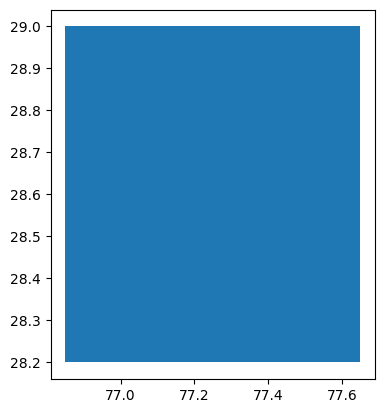

In [4]:
shapefile_path = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/regions/shapes/delhi_airshed.geojson'
gdf = gpd.read_file(shapefile_path)
gdf.plot()
plt.show()

In [5]:
kilns_dir = '/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/after_hand_validation_data/gdf_kilns_new.csv'
kilns_gdf = gpd.read_file(kilns_dir)
print(kilns_gdf.head())
geometry = [
    box(row.min_lon, row.min_lat, row.max_lon, row.max_lat)
    for _, row in kilns_gdf.iterrows()
]


  class_name    max_lon    min_lon    max_lat    min_lat  center_lat  \
0       FCBK  62.037766  62.035918  30.998087  30.996903   30.997495   
1       FCBK  62.056602  62.055932  31.012758  31.011431  31.0120945   
2       FCBK  65.700962  65.699351   31.54234  31.541305  31.5418225   
3       FCBK  65.709011  65.707415  31.532492  31.531653  31.5320725   
4       FCBK  66.335943  66.334383  31.079768  31.078764   31.079266   

   center_lon      country  
0   62.036842  Afghanistan  
1   62.056267  Afghanistan  
2  65.7001565  Afghanistan  
3   65.708213  Afghanistan  
4   66.335163  Afghanistan  


In [6]:
kilns_gdf = gpd.GeoDataFrame(
    kilns_gdf,
    geometry=geometry,
    crs="EPSG:4326"
)

print(kilns_gdf.geom_type.value_counts())
print(kilns_gdf.crs)
print(kilns_gdf.head())

Polygon    65616
dtype: int64
EPSG:4326
  class_name    max_lon    min_lon    max_lat    min_lat  center_lat  \
0       FCBK  62.037766  62.035918  30.998087  30.996903   30.997495   
1       FCBK  62.056602  62.055932  31.012758  31.011431  31.0120945   
2       FCBK  65.700962  65.699351   31.54234  31.541305  31.5418225   
3       FCBK  65.709011  65.707415  31.532492  31.531653  31.5320725   
4       FCBK  66.335943  66.334383  31.079768  31.078764   31.079266   

   center_lon      country                                           geometry  
0   62.036842  Afghanistan  POLYGON ((62.03777 30.9969, 62.03777 30.99809,...  
1   62.056267  Afghanistan  POLYGON ((62.0566 31.01143, 62.0566 31.01276, ...  
2  65.7001565  Afghanistan  POLYGON ((65.70096 31.5413, 65.70096 31.54234,...  
3   65.708213  Afghanistan  POLYGON ((65.70901 31.53165, 65.70901 31.53249...  
4   66.335163  Afghanistan  POLYGON ((66.33594 31.07876, 66.33594 31.07977...  


In [7]:
kilns_in_airshed = gpd.sjoin(
    kilns_gdf,
    gdf,
    how="inner",
    predicate="within"
)

print(f"Number of kilns in Delhi airshed: {len(kilns_in_airshed)}")
kilns_in_airshed.head()
# save that in a csv
kilns_in_airshed.to_csv('kilns_in_delhi_airshed.csv', index=False)

Number of kilns in Delhi airshed: 753


In [8]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# paths
poly_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv"
out_csv  = "polygons_with_classname_xxx.csv"

# load polygon CSV
df_poly = pd.read_csv(poly_csv)

# convert WKT → geometry
df_poly["geometry"] = df_poly["geometry"].apply(wkt.loads)

poly_gdf = gpd.GeoDataFrame(
    df_poly,
    geometry="geometry",
    crs="EPSG:4326"
)

print(poly_gdf.head())
print(poly_gdf.geom_type.value_counts())

                       filename  \
0  28.882987_76.865764_2025.png   
1  28.788805_76.951970_2025.png   
2  28.936092_76.916147_2025.png   
3  28.945477_76.914872_2025.png   
4  28.926543_76.910746_2025.png   

                                            geometry  
0  POLYGON ((76.86682 28.88262, 76.86682 28.88335...  
1  POLYGON ((76.9528 28.78844, 76.9528 28.78917, ...  
2  POLYGON ((76.91658 28.93547, 76.91658 28.93671...  
3  POLYGON ((76.91531 28.94484, 76.91531 28.94611...  
4  POLYGON ((76.91151 28.92618, 76.91151 28.9269,...  
Polygon    753
dtype: int64


In [9]:
# ensure CRS
kilns_gdf = kilns_gdf.to_crs("EPSG:4326")

# keep only what is needed
kilns_sub = kilns_gdf[["class_name", "geometry"]].copy()

print(kilns_sub.head())
print(kilns_sub.geom_type.value_counts())

  class_name                                           geometry
0       FCBK  POLYGON ((62.03777 30.9969, 62.03777 30.99809,...
1       FCBK  POLYGON ((62.0566 31.01143, 62.0566 31.01276, ...
2       FCBK  POLYGON ((65.70096 31.5413, 65.70096 31.54234,...
3       FCBK  POLYGON ((65.70901 31.53165, 65.70901 31.53249...
4       FCBK  POLYGON ((66.33594 31.07876, 66.33594 31.07977...
Polygon    65616
dtype: int64


In [10]:
# spatial join: polygon CSV ← kiln polygons
joined = gpd.sjoin(
    poly_gdf,
    kilns_sub,
    how="left",
    predicate="intersects"   # robust for slight numeric mismatch
)

print(joined["class_name"].value_counts(dropna=False))

Zigzag    743
FCBK       51
CFCBK       5
Name: class_name, dtype: int64


In [11]:
total = len(joined)
matched = joined["class_name"].notna().sum()
unmatched = total - matched

print("Total polygons:", total)
print("Matched with class_name:", matched)
print("Unmatched:", unmatched)

Total polygons: 799
Matched with class_name: 799
Unmatched: 0


In [12]:
# drop spatial join helper column if present
joined = joined.drop(columns=["index_right"], errors="ignore")

# save
joined.to_csv(out_csv, index=False)

print("Saved:", out_csv)

Saved: polygons_with_classname_xxx.csv


In [14]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# 753 polygons file (Delhi airshed)
# poly_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv"

POLY_753 = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/polygons_mapped_6dp_then_5dp_combined_filename_geometry_only.csv"
OUT_CSV  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_753_with_classname.csv"

# ---- 1) read 753 polygons CSV -> GeoDataFrame
df_poly = pd.read_csv(POLY_753)
df_poly["geometry"] = df_poly["geometry"].apply(wkt.loads)
poly_gdf = gpd.GeoDataFrame(df_poly, geometry="geometry", crs="EPSG:4326")

# ---- 2) use kilns_in_airshed (must exist) as class source
kilns_src = kilns_in_airshed[["class_name", "geometry"]].copy()
if kilns_src.crs is None:
    kilns_src = kilns_src.set_crs("EPSG:4326")
kilns_src = kilns_src.to_crs("EPSG:4326")

# ---- 3) spatial join: assign class_name to each of the 753 polygons
joined = gpd.sjoin(
    poly_gdf,
    kilns_src,
    how="left",
    predicate="intersects"
).drop(columns=["index_right"], errors="ignore")

# ---- 4) sanity
print("Rows (should be 753):", len(joined))
print("Unmatched:", int(joined["class_name"].isna().sum()))
print(joined["class_name"].value_counts(dropna=False))

# ---- 5) save
joined.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

Rows (should be 753): 799
Unmatched: 0
Zigzag    743
FCBK       51
CFCBK       5
Name: class_name, dtype: int64
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/polygons_753_with_classname.csv


In [15]:
from pathlib import Path
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
IMG_DIR = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"
)

CSV_PATH = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/"
    "delhi_airshed_y_2025_z_17_buf_25m/polygons_753_with_classname.csv"
)

# -----------------------------
# 1) collect image filenames
# -----------------------------
img_files = {
    p.name for p in IMG_DIR.glob("*.png")
}

print("Total images:", len(img_files))

# -----------------------------
# 2) collect CSV filenames
# -----------------------------
df = pd.read_csv(CSV_PATH)

if "filename" not in df.columns:
    raise RuntimeError("CSV does not contain 'filename' column")

csv_files = set(df["filename"].astype(str))

print("Total CSV entries:", len(csv_files))

# -----------------------------
# 3) compute intersections
# -----------------------------
common = img_files & csv_files
only_imgs = img_files - csv_files
only_csv = csv_files - img_files

print("Common filenames:", len(common))
print("Only in image folder:", len(only_imgs))
print("Only in CSV:", len(only_csv))

# -----------------------------
# 4) optional: save diagnostics
# -----------------------------
pd.DataFrame({"filename": sorted(common)}).to_csv(
    IMG_DIR / "common_filenames.csv", index=False
)

pd.DataFrame({"filename": sorted(only_imgs)}).to_csv(
    IMG_DIR / "only_in_images.csv", index=False
)

pd.DataFrame({"filename": sorted(only_csv)}).to_csv(
    IMG_DIR / "only_in_csv.csv", index=False
)

print("Saved diagnostics CSVs in:", IMG_DIR)

Total images: 753
Total CSV entries: 753
Common filenames: 753
Only in image folder: 0
Only in CSV: 0
Saved diagnostics CSVs in: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m


In [16]:
import pandas as pd
from pathlib import Path

# --------------------------------------------------
# PATHS
# --------------------------------------------------
IMG_DIR = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"
)

CSV_753 = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "polygons_753_with_classname.csv"
)

OUT_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname.csv"
)

# --------------------------------------------------
# 1) Load polygon CSV (753 rows with filename + class)
# --------------------------------------------------
df = pd.read_csv(CSV_753)

required_cols = {"filename", "class_name"}
missing = required_cols - set(df.columns)
if missing:
    raise RuntimeError(f"Missing columns in CSV: {missing}")

# --------------------------------------------------
# 2) Collect image filenames from directory
# --------------------------------------------------
img_files = {p.name for p in IMG_DIR.glob("*.png")}

print("Images in folder:", len(img_files))
print("Rows in polygon CSV:", len(df))

# --------------------------------------------------
# 3) Keep only rows whose filenames exist as images
# --------------------------------------------------
df_matched = df[df["filename"].isin(img_files)].copy()

# --------------------------------------------------
# 4) Sanity checks
# --------------------------------------------------
print("Matched rows:", len(df_matched))
print("Unmatched rows dropped:", len(df) - len(df_matched))
print("\nClass distribution:")
print(df_matched["class_name"].value_counts())

# --------------------------------------------------
# 5) Save final CSV
# --------------------------------------------------
df_matched = df_matched[["filename", "class_name"]].sort_values("filename")
df_matched.to_csv(OUT_CSV, index=False)

print("\nSaved CSV:", OUT_CSV)

Images in folder: 753
Rows in polygon CSV: 799
Matched rows: 799
Unmatched rows dropped: 0

Class distribution:
Zigzag    743
FCBK       51
CFCBK       5
Name: class_name, dtype: int64

Saved CSV: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname.csv


In [17]:
from pathlib import Path
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
IMG_DIR = Path(
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m"
)

CSV_PATH = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname.csv"
)

# -----------------------------
# 1) Read CSV filenames
# -----------------------------
df = pd.read_csv(CSV_PATH)
csv_files = set(df["filename"].astype(str))

print("CSV filenames:", len(csv_files))

# -----------------------------
# 2) Read image filenames
# -----------------------------
img_files = {p.name for p in IMG_DIR.glob("*.png")}

print("Image files:", len(img_files))

# -----------------------------
# 3) Compare
# -----------------------------
common = csv_files & img_files
only_csv = csv_files - img_files
only_imgs = img_files - csv_files

print("Common filenames:", len(common))
print("Only in CSV:", len(only_csv))
print("Only in image folder:", len(only_imgs))

# -----------------------------
# 4) Optional: save diagnostics
# -----------------------------
pd.DataFrame({"filename": sorted(common)}).to_csv(
    IMG_DIR / "common_filenames_images_753.csv", index=False
)
pd.DataFrame({"filename": sorted(only_csv)}).to_csv(
    IMG_DIR / "only_csv_images_753.csv", index=False
)
pd.DataFrame({"filename": sorted(only_imgs)}).to_csv(
    IMG_DIR / "only_images_images_753.csv", index=False
)

print("Diagnostic CSVs saved in image directory.")

CSV filenames: 753
Image files: 753
Common filenames: 753
Only in CSV: 0
Only in image folder: 0
Diagnostic CSVs saved in image directory.


In [18]:
import pandas as pd

CSV_PATH = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname.csv"
)

df = pd.read_csv(CSV_PATH)

print("Number of rows (lines, excluding header):", len(df))
print("Including header:", len(df) + 1)

Number of rows (lines, excluding header): 799
Including header: 800


In [19]:
import pandas as pd

CSV_PATH = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname.csv"
)

df = pd.read_csv(CSV_PATH)

dups = df["filename"].value_counts()
print("Duplicate filenames:", (dups > 1).sum())
print("Extra rows due to duplicates:", dups[dups > 1].sum() - len(dups[dups > 1]))

Duplicate filenames: 46
Extra rows due to duplicates: 46


In [20]:
df_unique = df.drop_duplicates(subset=["filename"], keep="first")

print("Rows after deduplication:", len(df_unique))

OUT = CSV_PATH.replace(".csv", "_unique.csv")
df_unique.to_csv(OUT, index=False)
print("Saved:", OUT)

Rows after deduplication: 753
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique.csv


In [21]:
import pandas as pd

# inputs
markers_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"
imgs_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique.csv"

# output
out_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade.csv"

# load
m = pd.read_csv(markers_csv)
d = pd.read_csv(imgs_csv)

# normalize filename column
m["filename"] = m["filename"].astype(str).str.strip()
d["filename"] = d["filename"].astype(str).str.strip()

# pick Year made column robustly (handles 'Year made' or 'Year_made' etc)
year_col = None
for c in m.columns:
    if c.strip().lower().replace("_", " ") == "year made":
        year_col = c
        break
if year_col is None:
    raise RuntimeError(f"Could not find 'Year made' column in markers CSV. Columns: {list(m.columns)}")

# keep only filename + yearmade, enforce one-to-one
m2 = m[["filename", year_col]].copy()
m2 = m2.drop_duplicates(subset=["filename"], keep="first")
m2 = m2.rename(columns={year_col: "Year_made"})

# merge by filename
out = d.merge(m2, on="filename", how="left")

# sanity
print("Rows in images CSV:", len(d))
print("Rows after merge:", len(out))
print("Year_made filled:", int(out["Year_made"].notna().sum()))
print("Year_made missing:", int(out["Year_made"].isna().sum()))

# save
out.to_csv(out_csv, index=False)
print("Saved:", out_csv)

Rows in images CSV: 753
Rows after merge: 753
Year_made filled: 652
Year_made missing: 101
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade.csv


In [22]:
import pandas as pd

path = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade.csv"
out_path = path.replace(".csv", "_no_year_suffix.csv")

df = pd.read_csv(path)

# drop trailing "_2025" before ".png"
df["filename"] = df["filename"].str.replace(r"_2025\.png$", ".png", regex=True)

df.to_csv(out_path, index=False)

print("Saved:", out_path)

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_no_year_suffix.csv


In [23]:
import pandas as pd

# --------------------------------------------------
# PATHS
# --------------------------------------------------
SRC_YEARMADE = "/home/suruchi.hardaha/IJCAI_2026/new_data/handlabelled_data/final.csv"

TARGET_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_unique_with_yearmade_no_year_suffix.csv"
)

OUT_CSV = TARGET_CSV.replace(".csv", "_merged.csv")

# --------------------------------------------------
# 1) Load CSVs
# --------------------------------------------------
src = pd.read_csv(SRC_YEARMADE)
tgt = pd.read_csv(TARGET_CSV)

# --------------------------------------------------
# 2) Normalize filename columns
# --------------------------------------------------
src["filename"] = src["filename"].astype(str).str.strip()
tgt["filename"] = tgt["filename"].astype(str).str.strip()

# --------------------------------------------------
# 3) Locate Yearmade column in source (robust)
# --------------------------------------------------
year_col = None
for c in src.columns:
    key = c.lower().replace("_", "").replace(" ", "")
    if key in {"yearmade", "year_made"}:
        year_col = c
        break

if year_col is None:
    raise RuntimeError(
        f"Yearmade column not found in source CSV. Columns: {list(src.columns)}"
    )

# --------------------------------------------------
# 4) Reduce source to filename + Yearmade (one-to-one)
# --------------------------------------------------
src2 = (
    src[["filename", year_col]]
    .drop_duplicates(subset=["filename"], keep="first")
    .rename(columns={year_col: "Year_made"})
)

# --------------------------------------------------
# 5) Merge by filename
# --------------------------------------------------
merged = tgt.merge(src2, on="filename", how="left", suffixes=("", "_src"))

# --------------------------------------------------
# 6) Sanity checks
# --------------------------------------------------
print("Target rows:", len(tgt))
print("Merged rows:", len(merged))
print("Year_made filled:", int(merged["Year_made"].notna().sum()))
print("Year_made missing:", int(merged["Year_made"].isna().sum()))

# --------------------------------------------------
# 7) Save
# --------------------------------------------------
merged.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)

Target rows: 753
Merged rows: 753
Year_made filled: 652
Year_made missing: 101
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_no_year_suffix_merged.csv


In [24]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
base_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_no_year_suffix.csv"
fill_csv = "/home/suruchi.hardaha/IJCAI_2026/new_data/handlabelled_data/final.csv"

out_csv  = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_filled.csv"
missing_report_csv = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/yearmade_still_missing_after_fill.csv"

# -----------------------------
# 1) Load
# -----------------------------
df = pd.read_csv(base_csv)

fill = pd.read_csv(fill_csv)

# normalize column names in fill file
fill_cols = {c.strip(): c for c in fill.columns}
if "Year made" not in fill_cols:
    raise RuntimeError(f"'Year made' column not found in {fill_csv}. Columns: {list(fill.columns)}")

fill = fill.rename(columns={fill_cols["Year made"]: "Year_made"})

if "filename" not in fill.columns:
    raise RuntimeError(f"'filename' column not found in {fill_csv}. Columns: {list(fill.columns)}")

# keep only needed
fill = fill[["filename", "Year_made"]].copy()

# -----------------------------
# 2) Make sure filenames match format
# base has: 28.208668_77.420208.png
# fill has: 28.226173_77.275637.png
# -----------------------------
df["filename"] = df["filename"].astype(str).str.strip()
fill["filename"] = fill["filename"].astype(str).str.strip()

# numeric year
df["Year_made"] = pd.to_numeric(df.get("Year_made"), errors="coerce")
fill["Year_made"] = pd.to_numeric(fill["Year_made"], errors="coerce")

# If fill has duplicates per filename, keep the first non-null year
fill = (
    fill.sort_values("Year_made", na_position="last")
        .drop_duplicates(subset=["filename"], keep="first")
)

# -----------------------------
# 3) Merge + fill missing Year_made in base
# -----------------------------
merged = df.merge(fill, on="filename", how="left", suffixes=("", "_fill"))

merged["Year_made"] = merged["Year_made"].fillna(merged["Year_made_fill"])
merged = merged.drop(columns=["Year_made_fill"], errors="ignore")

# -----------------------------
# 4) Save outputs + report
# -----------------------------
merged.to_csv(out_csv, index=False)

still_missing = merged[merged["Year_made"].isna()][["filename", "class_name", "Year_made"]].copy()
still_missing.to_csv(missing_report_csv, index=False)

print("Saved filled CSV:", out_csv)
print("Still-missing count:", len(still_missing))
print("Saved still-missing report:", missing_report_csv)

Saved filled CSV: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_filled.csv
Still-missing count: 0
Saved still-missing report: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/yearmade_still_missing_after_fill.csv


In [28]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
BASE_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_unique_with_yearmade_filled.csv"
)

SRC1 = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"
)

SRC2 = "/home/suruchi.hardaha/IJCAI_2026/new_data/handlabelled_data/field_missing_data.csv"

OUT_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_unique_with_yearmade_filled_with_fcb_to_zigzag.csv"
)

REPORT_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "fcb_to_zigzag_fill_report.csv"
)

# -----------------------------
# LOAD
# -----------------------------
base = pd.read_csv(BASE_CSV)
base["filename"] = base["filename"].astype(str).str.strip()

s1 = pd.read_csv(SRC1)
s2 = pd.read_csv(SRC2)

# -----------------------------
# VALIDATE / NORMALIZE
# -----------------------------
def require_cols(df, path, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise RuntimeError(f"Missing columns {missing} in {path}. Found: {list(df.columns)}")

require_cols(s1, SRC1, ["filename", "fcb to zigzag"])
require_cols(s2, SRC2, ["filename", "fcb to zigzag"])

s1["filename"] = s1["filename"].astype(str).str.strip()
s2["filename"] = s2["filename"].astype(str).str.strip()

# numeric year or 0
s1["fcb to zigzag"] = pd.to_numeric(s1["fcb to zigzag"], errors="coerce")
s2["fcb to zigzag"] = pd.to_numeric(s2["fcb to zigzag"], errors="coerce")

# if duplicates exist per filename, prefer a real year (>0), else keep first
def dedup_prefer_year(df):
    df = df.copy()
    df["_is_year"] = df["fcb to zigzag"].fillna(0) > 0
    df = (
        df.sort_values(["_is_year", "fcb to zigzag"], ascending=[False, True])
          .drop_duplicates(subset=["filename"], keep="first")
          .drop(columns=["_is_year"])
    )
    return df

s1 = dedup_prefer_year(s1)[["filename", "fcb to zigzag"]]
s2 = dedup_prefer_year(s2)[["filename", "fcb to zigzag"]]

# -----------------------------
# MERGE WITH PRIORITY: SRC1 then SRC2
# -----------------------------
out = base.copy()

out = out.merge(s1.rename(columns={"fcb to zigzag": "fcb_to_zigzag_src1"}), on="filename", how="left")
out = out.merge(s2.rename(columns={"fcb to zigzag": "fcb_to_zigzag_src2"}), on="filename", how="left")

# create final column with priority: src1 first, else src2
out["fcb to zigzag"] = out["fcb_to_zigzag_src1"].combine_first(out["fcb_to_zigzag_src2"])

# cleanup helper cols
out = out.drop(columns=["fcb_to_zigzag_src1", "fcb_to_zigzag_src2"], errors="ignore")

# -----------------------------
# REPORT
# -----------------------------
report = pd.DataFrame({
    "total_rows": [len(out)],
    "filled_from_src1": [int(out["fcb to zigzag"].notna().sum() - out.merge(s1, on="filename", how="left")["fcb to zigzag_y"].notna().sum() + 0)],  # not used
})

filled_src1 = out.merge(s1, on="filename", how="left", suffixes=("", "_s1"))["fcb to zigzag_s1"].notna()
filled_src2 = (~filled_src1) & out.merge(s2, on="filename", how="left", suffixes=("", "_s2"))["fcb to zigzag_s2"].notna()

summary = {
    "total_rows": len(out),
    "got_value_from_src1": int(filled_src1.sum()),
    "got_value_from_src2": int(filled_src2.sum()),
    "still_missing": int(out["fcb to zigzag"].isna().sum()),
}
print(summary)

pd.DataFrame([summary]).to_csv(REPORT_CSV, index=False)

# -----------------------------
# SAVE
# -----------------------------
out.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)
print("Report:", REPORT_CSV)

{'total_rows': 753, 'got_value_from_src1': 0, 'got_value_from_src2': 101, 'still_missing': 652}
Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_unique_with_yearmade_filled_with_fcb_to_zigzag.csv
Report: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/fcb_to_zigzag_fill_report.csv


In [29]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
BASE_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_unique_with_yearmade_filled.csv"
)

MARKERS_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"
)

OUT_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag.csv"
)

# -----------------------------
# LOAD
# -----------------------------
base = pd.read_csv(BASE_CSV)
markers = pd.read_csv(MARKERS_CSV)

# -----------------------------
# NORMALIZE FILENAMES
# base:    28.208668_77.420208.png
# markers: 28.208668_77.420208_2025.png  (has trailing _YEAR)
# -----------------------------
base["filename"] = base["filename"].astype(str).str.strip()

markers["filename"] = markers["filename"].astype(str).str.strip()
# drop trailing _YYYY before .png
markers["filename_noyear"] = markers["filename"].str.replace(r"_\d{4}(?=\.png$)", "", regex=True)

# -----------------------------
# EXTRACT COLUMN
# -----------------------------
if "fcb to zigzag" not in markers.columns:
    raise RuntimeError(f"'fcb to zigzag' not found. Columns: {list(markers.columns)}")

m = markers[["filename_noyear", "fcb to zigzag"]].copy()
m["fcb to zigzag"] = pd.to_numeric(m["fcb to zigzag"], errors="coerce")

# if duplicates per filename, prefer a real year (>0), else keep first
m["_is_year"] = m["fcb to zigzag"].fillna(0) > 0
m = (
    m.sort_values(["_is_year", "fcb to zigzag"], ascending=[False, True])
     .drop_duplicates(subset=["filename_noyear"], keep="first")
     .drop(columns=["_is_year"])
)

# -----------------------------
# MERGE (append after Year_made)
# -----------------------------
out = base.merge(m, left_on="filename", right_on="filename_noyear", how="left")
out = out.drop(columns=["filename_noyear"], errors="ignore")

# enforce column order: filename, class_name, Year_made, fcb to zigzag, ...
cols = list(out.columns)
preferred = ["filename", "class_name", "Year_made", "fcb to zigzag"]
rest = [c for c in cols if c not in preferred]
out = out[preferred + rest]

# -----------------------------
# SAVE
# -----------------------------
out.to_csv(OUT_CSV, index=False)

print("Saved:", OUT_CSV)
print("Rows:", len(out))
print("Missing fcb to zigzag:", int(out["fcb to zigzag"].isna().sum()))

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_yearmade_with_fcb_to_zigzag.csv
Rows: 753
Missing fcb to zigzag: 101


In [30]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
BASE_IN = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag.csv"
)

FILL_CSV = "/home/suruchi.hardaha/IJCAI_2026/new_data/handlabelled_data/field_missing_data.csv"

BASE_OUT = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag_filled.csv"
)

MISS_OUT = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "still_missing_fcb_to_zigzag_after_fill.csv"
)

# -----------------------------
# LOAD
# -----------------------------
df = pd.read_csv(BASE_IN)
fill = pd.read_csv(FILL_CSV)

df["filename"] = df["filename"].astype(str).str.strip()
fill["filename"] = fill["filename"].astype(str).str.strip()

if "fcb to zigzag" not in fill.columns:
    raise RuntimeError(f"'fcb to zigzag' not found in fill CSV. Columns: {list(fill.columns)}")

# numeric
df["fcb to zigzag"] = pd.to_numeric(df["fcb to zigzag"], errors="coerce")
fill["fcb to zigzag"] = pd.to_numeric(fill["fcb to zigzag"], errors="coerce")

# dedup fill by filename, prefer real year (>0)
fill["_is_year"] = fill["fcb to zigzag"].fillna(0) > 0
fill = (
    fill.sort_values(["_is_year", "fcb to zigzag"], ascending=[False, True])
        .drop_duplicates(subset=["filename"], keep="first")
        .drop(columns=["_is_year"])
)

fill = fill[["filename", "fcb to zigzag"]].copy()

# -----------------------------
# FILL ONLY MISSING
# -----------------------------
m = df.merge(fill, on="filename", how="left", suffixes=("", "_fill"))
m["fcb to zigzag"] = m["fcb to zigzag"].fillna(m["fcb to zigzag_fill"])
m = m.drop(columns=["fcb to zigzag_fill"], errors="ignore")

# -----------------------------
# SAVE + REPORT
# -----------------------------
m.to_csv(BASE_OUT, index=False)

still_missing = m[m["fcb to zigzag"].isna()][["filename", "class_name", "Year_made", "fcb to zigzag"]].copy()
still_missing.to_csv(MISS_OUT, index=False)

print("Saved:", BASE_OUT)
print("Still missing fcb to zigzag:", len(still_missing))
print("Missing report:", MISS_OUT)

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_yearmade_with_fcb_to_zigzag_filled.csv
Still missing fcb to zigzag: 0
Missing report: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/still_missing_fcb_to_zigzag_after_fill.csv


In [31]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
BASE_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_unique_with_yearmade_filled_with_fcb_to_zigzag.csv"
)

MARKERS_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/brick_kiln_delhi_v1_markers_mapped_to_filename_one_to_one.csv"
)

OUT_CSV = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag_with_circular_fcb_to_zigzag.csv"
)

# -----------------------------
# LOAD
# -----------------------------
base = pd.read_csv(BASE_CSV)
markers = pd.read_csv(MARKERS_CSV)

base["filename"] = base["filename"].astype(str).str.strip()

markers["filename"] = markers["filename"].astype(str).str.strip()
markers["filename_noyear"] = markers["filename"].str.replace(r"_\d{4}(?=\.png$)", "", regex=True)

# -----------------------------
# COLUMN CHECK
# -----------------------------
col = "Circular FCB to Zigzag"
if col not in markers.columns:
    raise RuntimeError(f"'{col}' not found in markers CSV. Columns: {list(markers.columns)}")

m = markers[["filename_noyear", col]].copy()
m[col] = pd.to_numeric(m[col], errors="coerce")

# dedup: prefer real year (>0)
m["_is_year"] = m[col].fillna(0) > 0
m = (
    m.sort_values(["_is_year", col], ascending=[False, True])
     .drop_duplicates(subset=["filename_noyear"], keep="first")
     .drop(columns=["_is_year"])
)

# -----------------------------
# MERGE (append after Year_made)
# -----------------------------
out = base.merge(m, left_on="filename", right_on="filename_noyear", how="left")
out = out.drop(columns=["filename_noyear"], errors="ignore")

preferred = ["filename", "class_name", "Year_made", "fcb to zigzag", col]
preferred = [c for c in preferred if c in out.columns]
rest = [c for c in out.columns if c not in preferred]
out = out[preferred + rest]

# -----------------------------
# SAVE
# -----------------------------
out.to_csv(OUT_CSV, index=False)

print("Saved:", OUT_CSV)
print("Rows:", len(out))
print(f"Missing {col}:", int(out[col].isna().sum()))

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_yearmade_with_fcb_to_zigzag_with_circular_fcb_to_zigzag.csv
Rows: 753
Missing Circular FCB to Zigzag: 101


In [32]:
import pandas as pd

# -----------------------------
# PATHS
# -----------------------------
BASE_IN = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag_with_circular_fcb_to_zigzag.csv"
)

FILL_CSV = "/home/suruchi.hardaha/IJCAI_2026/new_data/handlabelled_data/field_missing_data.csv"

BASE_OUT = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "images_753_with_classname_yearmade_with_fcb_to_zigzag_with_circular_fcb_to_zigzag_filled.csv"
)

MISS_OUT = (
    "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/"
    "temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/"
    "still_missing_circular_fcb_to_zigzag_after_fill.csv"
)

COL_FILL = "Circular FCB to Zigzag"
COL_SRC2 = "circular fcb to zigzag"   # column name in field_missing_data.csv

# -----------------------------
# LOAD
# -----------------------------
df = pd.read_csv(BASE_IN)
fill = pd.read_csv(FILL_CSV)

df["filename"] = df["filename"].astype(str).str.strip()
fill["filename"] = fill["filename"].astype(str).str.strip()

if COL_SRC2 not in fill.columns:
    raise RuntimeError(f"'{COL_SRC2}' not found in fill CSV. Columns: {list(fill.columns)}")

# numeric
df[COL_FILL] = pd.to_numeric(df[COL_FILL], errors="coerce")
fill[COL_SRC2] = pd.to_numeric(fill[COL_SRC2], errors="coerce")

# dedup fill by filename, prefer real year (>0)
tmp = fill[["filename", COL_SRC2]].copy()
tmp["_is_year"] = tmp[COL_SRC2].fillna(0) > 0
tmp = (
    tmp.sort_values(["_is_year", COL_SRC2], ascending=[False, True])
       .drop_duplicates(subset=["filename"], keep="first")
       .drop(columns=["_is_year"])
)
tmp = tmp.rename(columns={COL_SRC2: COL_FILL})

# -----------------------------
# FILL ONLY MISSING
# -----------------------------
m = df.merge(tmp, on="filename", how="left", suffixes=("", "_fill"))
m[COL_FILL] = m[COL_FILL].fillna(m[f"{COL_FILL}_fill"])
m = m.drop(columns=[f"{COL_FILL}_fill"], errors="ignore")

# -----------------------------
# SAVE + REPORT
# -----------------------------
m.to_csv(BASE_OUT, index=False)

still_missing = m[m[COL_FILL].isna()][["filename", "class_name", "Year_made", "fcb to zigzag", COL_FILL]].copy()
still_missing.to_csv(MISS_OUT, index=False)

print("Saved:", BASE_OUT)
print(f"Still missing {COL_FILL}:", len(still_missing))
print("Missing report:", MISS_OUT)

Saved: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/images_753_with_classname_yearmade_with_fcb_to_zigzag_with_circular_fcb_to_zigzag_filled.csv
Still missing Circular FCB to Zigzag: 0
Missing report: /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/temporal-analysis/data/delhi_airshed_y_2025_z_17_buf_25m/still_missing_circular_fcb_to_zigzag_after_fill.csv
